In [1]:
import librosa.display
import librosa.feature
import numpy as np
import scipy.signal
import glob


# t-2 Voice Activity Detection function
def detect_activity(y, sr,
        n_mels=128, fmin=1000, fmax=11025, 
        hop_length=512, gain=0.8, bias=10, power=0.25, pcen_time_constant=0.06, eps=1e-06,
        medfilt_time_constant=None, normalized=True,
        peak_threshold=0.45, activity_threshold=0.2):
    
    # 1. Compute mel-frequency spectrogram
    melspec = librosa.feature.melspectrogram(
        y, sr=sr, fmin=fmin, fmax=fmax, hop_length=hop_length,
        n_mels=n_mels)
    
    # 2. Compute per-channel energy normalization (PCEN-SNR)
    pcen = librosa.core.pcen(melspec, sr=sr, gain=gain, bias=bias,
        power=power, hop_length=hop_length,
        time_constant=pcen_time_constant, eps=eps)
    
    # 3. compute PCEN-SNR detection function
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    if normalized:
        pcen_snr = pcen_snr / np.max(pcen_snr)
        
    # 4. Apply median filtering.
    if medfilt_time_constant is not None:
        medfilt_hops = medfilt_time_constant * sr / hop_length
        kernel_size = max(1, 1 + 2 * round(medfilt_hops - 0.5))
        pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
    
    # 5. Extract active segments.
    activity, start, end = threshold_activity(
        pcen_snr, peak_threshold, activity_threshold)
    
    # 6. Convert indices to seconds.
    start_times = np.round(np.array(start) * hop_length / sr, 3)
    end_times = np.round(np.array(end) * hop_length / sr, 3)
    
    return start_times, end_times, pcen


def threshold_activity(x, Tp, Ta):
    locs = scipy.signal.find_peaks(x,height = Tp)[0]
    y = (x > Ta) * 1
    act = np.diff(y)
    u = np.where(act == 1)[0]
    d = np.where(act == -1)[0]
    signal_length = len(x)
    
    if d[0] < u[0]:
        u = np.insert(u, 0, 0)
        
    if d[-1] < u[-1]:
        d = np.append(d, signal_length-1)
        
    starts = []
    ends = []
    
    activity = np.zeros(signal_length,)
    
    for candidate_up, candidate_down in zip(u, d):
        candidate_segment = range(candidate_up, candidate_down)
        peaks_in_segment = [x in candidate_segment for x in locs]
        is_valid_candidate = np.any(peaks_in_segment)
        if is_valid_candidate:
            starts.append(candidate_up)
            ends.append(candidate_down)
            activity[candidate_segment] = 1.0
            
    starts = np.array(starts)
    ends = np.array(ends)
    
    return activity, starts, ends


def get_events_time(rdata):

    rdata_nz = np.nonzero(rdata)[0][-1]
    fdata = rdata[0:rdata_nz]
        
    S = librosa.feature.melspectrogram(fdata,n_mels = 256,n_fft=2048, hop_length = 512)
    pcen = librosa.core.pcen(S, sr=44100,
    gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06)
    
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    pcen_snr = pcen_snr / np.max(pcen_snr)
    median_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=3)
    
    activity, start, end = threshold_activity(median_pcen_snr,0.45,0.15)
    activity_count = len(start)
    
    return start, end, pcen


def get_coef(start, end, pcen):

    a_all = []
    b_all = []
    max_list = []
    min_list = []
    poly_coef = []
        
    for s,e in zip(start,end):   
        bins = np.argmax(pcen[:,s:e],0)
        bins_filt = bins[(bins < np.mean(bins) + 2*np.std(bins)) & (bins > np.mean(bins) - 2*np.std(bins)) & (bins<200)& (bins>5)]

        if len(bins_filt) > 2:
            x = np.array(range(0,len(bins_filt)))
            x = x - np.mean(x)
            z = np.polyfit(x, bins_filt, 2)

            p = np.poly1d(z)
            a = z[0]
            b = z[1]
            poly_coef = np.append(poly_coef, z[0:2])
    
            # Store needed variables - coefficients, max and min
            a_all = np.append(a_all,a)
            b_all = np.append(b_all,b)
            xp = np.linspace(x.min(), x.max(), len(bins_filt))
            max_list = np.append(max_list,x.max())
            min_list = np.append(min_list,x.min())

    return a_all, b_all, max_list, min_list




def pitch_contour(a_sti_all,b_sti_all,max_sti_list,min_sti_list):
    sti_states = []
    for a,b,amax,amin in zip(a_sti_all,b_sti_all,max_sti_list,min_sti_list):
        if a > 0.01:
            if -b / (2*a) <= amin:
                seq = 'uuu'
            elif 0 >= -b / (2*a) > amin :
                seq = 'duu'
            elif amax > -b / (2*a) > 0:
                seq = 'ddu'
            else:
                seq = 'ddd'
            
        elif a < -0.01:
            if -b / (2*a) <= amin:
                seq = 'ddd'
            elif 0 >= -b / (2*a) > amin :
                seq = 'udd'
            elif amax > -b / (2*a) > 0:
                seq = 'uud'
            else:
                seq = 'uuu'
            
        else:
            if b > 0.1:
                seq = 'uuu'
            elif b < -0.1:
                seq = 'ddd'
            else:
                seq = 'fff'
                
        sti_states.append(seq)  
    return sti_states


def pitch_countour_numerical(states_str):
    state_list = ['uuu', 'duu', 'ddu', 'ddd', 'udd', 'uud', 'fff']
    states_int = []
    for state_str in states_str:
        states_int.append([i for i,s in enumerate(state_list) if state_str == s])
        
    return states_int

def pitch_countour_numerical_from_coefs(a_sti_all,b_sti_all,max_sti_list,min_sti_list):
    state_list = ['uuu', 'duu', 'ddu', 'ddd', 'udd', 'uud', 'fff']
    sti_states = pitch_contour(a_sti_all,b_sti_all,max_sti_list,min_sti_list)
    state_int = []
    for state_str in sti_states:
        states_int.append([i for i,s in enumerate(state_list) if state_str == s])
        
    return states_int[0]

In [2]:
import glob
import tqdm
import h5py

# select participants and spcies
participant_paths = np.array(glob.glob("imitations_participant*.mat"))
participant_paths.sort()
#participant_paths = participant_paths[([0, 4, 5, 8, 10, 11])]

n_participants = len(participant_paths)
n_imitations = 100
n_species = 10
imitation_matrix = []
stimulus_matrix = []
species_matrix = []

species_subset = np.array([4, 5, 8, 10])
#imitation_subset = np.zeros(n_imitations)
#for n in species_subset:
#    imitation_subset[range(n*10-10, n*10)] = 1
#imitation_subset = np.array(np.where(imitation_subset)).tolist()[0]

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    stimulus_list = []
    species_list = []
    
    with h5py.File(participant_path) as h5_file:
        for i in range(n_imitations):#imitation_subset:
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            stimulus_waveform = h5_file['#refs#'][
                h5_file["imitations"]["stimulusAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            
            imitation_list.append(imitation_waveform)
            stimulus_list.append(stimulus_waveform)
            species_list.append(species)
            
        imitation_matrix.append(imitation_list)
        stimulus_matrix.append(stimulus_list)
        species_matrix.append(species_list)
        
imitation_matrix = np.array(imitation_matrix)
stimulus_matrix = np.array(stimulus_matrix)
stimulus_matrix = stimulus_matrix[0,:]
species_matrix = np.array(species_matrix)

n_species = int(stimulus_matrix.shape[0] / 10)
n_imitations = int(imitation_matrix.shape[0] * imitation_matrix.shape[1])
n_participants = imitation_matrix.shape[0]

100%|██████████| 17/17 [00:23<00:00,  1.42s/it]


In [3]:
# getting the polynomial's vertex and first coefficient

a_stim_list = []
b_stim_list = []

a_imit_matrix = []
b_imit_matrix = []

for i_stimulus in np.arange(n_species * 10):
    #print('----%d' %i_stimulus)
    stim = stimulus_matrix[i_stimulus]
    stim = stim[2:-1]
    starts, ends, pcen = get_events_time(stim)
    a, b, max_list, min_list = get_coef(starts, ends, pcen)
    a_stim_list.append(a)
    b_stim_list.append(b)
    
    a_imit_list = []
    b_imit_list = []
    
    for i_participant in np.arange(n_participants):
        #print(i_participant)
        imit = imitation_matrix[i_participant, i_stimulus]
        imit = imit[2:-1]
        starts, ends, pcen = get_events_time(imit)
        a, b, max_list, min_list= get_coef(starts, ends, pcen)
        a_imit_list.append(a)
        b_imit_list.append(b)
    a_imit_matrix.append(a_imit_list)
    b_imit_matrix.append(b_imit_list)
        
a_stim_list = np.array(a_stim_list)
b_stim_list = np.array(b_stim_list)

a_imit_matrix = np.array(a_imit_matrix)
b_imit_matrix = np.array(b_imit_matrix)


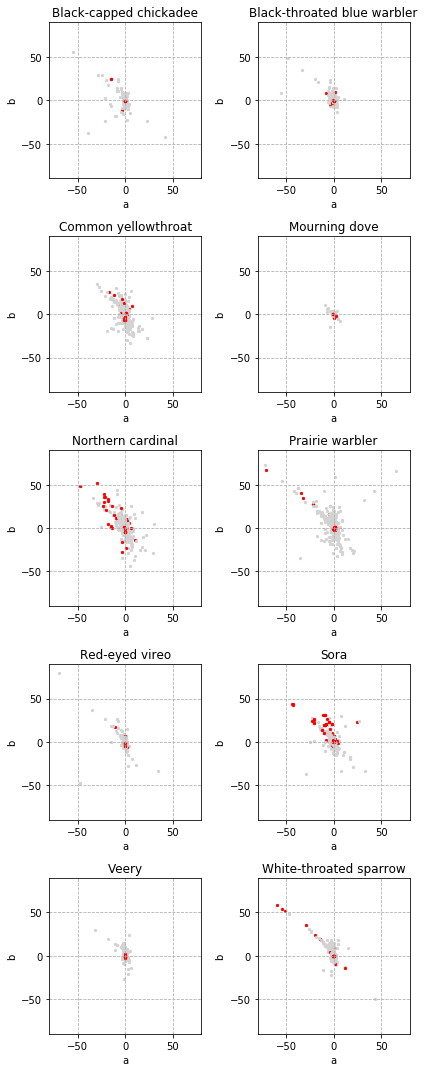

In [4]:
# plot a vs b
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

species_names = ['Black-capped chickadee',
                 'Black-throated blue warbler',
                 'Common yellowthroat',
                 'Mourning dove',
                 'Northern cardinal',
                 'Prairie warbler',
                 'Red-eyed vireo',
                 'Sora',
                 'Veery',
                 'White-throated sparrow']

n_stimuli = 10

colors_stim = ['red','green','blue','purple']
colors_imit = ['lightsalmon','lightgreen','skyblue','plum']
marker_size = 5

plt.figure(figsize=(6,15))

c = -1
for i_species in np.arange(n_species):
    plt.subplot(5,2,i_species+1)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.xlim((-80,80))
    plt.ylim((-90,90))
    #plt.title(species_names[species_subset[i_species]-1])
    plt.title(species_names[i_species])
    plt.grid(linestyle='--')
    #plt.legend(title='light=imitations; dark=birdsong')
    
    for i_stimulus in np.arange(n_stimuli):
        c = c + 1
        
        for i_participant in np.arange(n_participants):
            a = a_imit_matrix[c, i_participant]
            b = b_imit_matrix[c, i_participant]
            plt.scatter(a, b, color='lightgrey',#colors_imit[i_species],
                       s=marker_size)
            
        a = a_stim_list[c]
        b = b_stim_list[c]
        plt.scatter(a, b, color='r',#colors_stim[i_species],
                   s=marker_size)
        
plt.tight_layout()

## Extras

In [5]:
# getting the states

need_stimuli = stimulus_matrix
need_data = imitation_matrix

states_sti_list = []
states_im_matrix = []

for i in np.arange(n_species * 10):   
    rdata_sti = need_stimuli[i]
    rdata_sti = rdata_sti[2:-1]
    start_sti, end_sti, pcen_sti = get_events_time(rdata_sti)
    a_sti, b_sti, max_list_sti, min_list_sti = get_coef(start_sti, end_sti, pcen_sti)
    states_sti = pitch_contour(a_sti, b_sti, max_list_sti, min_list_sti)
    states_sti_list.append(states_sti)
    
    states_im_list = []
    for j in np.arange(n_participants):
        rdata = need_data[j, i]
        rdata = rdata[2:-1]
        start, end, pcen = get_events_time(rdata)
        a, b, max_list, min_list = get_coef(start, end, pcen)
        states_im = pitch_contour(a, b, max_list, min_list)
        states_im_list.append(states_im)
    states_im_matrix.append(states_im_list)
        
states_sti_list = np.array(states_sti_list)
states_im_matrix = np.array(states_im_matrix).T

